In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap
import pandas as pd

import tensorly as tl
import tensorly.decomposition

from tqdm.notebook import tqdm

In [3]:
dir_github        = str(Path(r'D:\RH_local\github').resolve())

dir_analysisFiles = Path(r'D:\RH_local\data\BMI_cage_1511_3\mouse_B\20221020\analysis_data').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'D:\RH_local\data\BMI_cage_1511_3\mouse_B\20221020\analysis_data\suite2p\plane0').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


# dir_save       =  copy.copy(dir_analysisFiles)
# # path_save = dir_save / 'weights_day0'
# path_save = dir_save / 'weights_day0_PC2'

In [4]:
import sys
sys.path.append(dir_github)

In [5]:
from basic_neural_processing_modules import path_helpers, image_processing, timeSeries

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [6]:
import ScanImageTiffReader

In [7]:
import torch

In [8]:
path_stack = r'D:/RH_local/data/BMI_cage_1511_3/mouse_B/20221020/analysis_data/stack_warped.mat'

In [9]:
dir_vids = r'D:/RH_local/data/BMI_cage_1511_3/mouse_B/20221020/scanimage_data/'

In [48]:
def phase_correlation(ims_template, im_moving, template_precomputed=False):
    """
    Perform phase correlation on two images.
    RH 2022
    
    Args:
        im_template (torch.ndarray):
            Template image
        im_moving (torch.ndarray):
            Moving image
        template_precomputed (bool):
            If True, im_template is assumed to be:
             torch.conj(torch.fft.fft2(im_template) * mask_fft)
    
    Returns:
        cc (torch.ndarray):
            Phase correlation coefficient.
            Middle of image is zero-shift.
    """
    
    
    fft_template = torch.conj(torch.fft.fft2(ims_template)) if not template_precomputed else im_template
    fft_moving   = torch.fft.fft2(ims_moving)
    R = fft_template * fft_moving
    cc = torch.fft.fftshift(torch.fft.ifft2(R)).real
    return cc

In [10]:
stack = scipy.io.loadmat(path_stack, simplify_cells=True)['stack_warped']['stack_avg']

In [11]:
paths_vids = path_helpers.get_paths(dir_vids, reMatch='baseline_0.*.tif')

In [12]:
paths_vids

['D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00001.tif',
 'D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00002.tif',
 'D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00003.tif',
 'D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00004.tif',
 'D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00005.tif',
 'D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00006.tif',
 'D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00007.tif',
 'D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00008.tif',
 'D:\\RH_local\\data\\BMI_cage_1511_3\\mouse_B\\20221020\\scanimage_data\\baseline\\baseline_00001_00009.tif',
 

In [13]:
def crop(ims, c_lr, c_ud):
    if ims.ndim == 2:
        return ims[c_ud[0]:c_ud[1], c_lr[0]:c_lr[1]]
    if ims.ndim == 3:
        return ims[:, c_ud[0]:c_ud[1], c_lr[0]:c_lr[1]]

In [138]:
idx_a, idx_m, idx_b = [1,2,3]
crops = np.array([[256, 512+256], [0, 512]])

sitr = ScanImageTiffReader.ScanImageTiffReader

# template_precomp = torch.as_tensor(np.conj(np.fft.fft2(crop(stack[idx_a], *crops))), dtype=torch.complex64)
# cc_a = [[phase_correlation(template_precomp, m, template_precomputed=True)[255:256, 255:256].mean() for m in tqdm(crop(torch.as_tensor(sitr(path).data(), dtype=torch.float32), *crops))] for path in tqdm(paths_vids[:7])]

template_precomp = torch.as_tensor(np.conj(np.fft.fft2(crop(stack[idx_m], *crops))), dtype=torch.complex64)
cc_m = [[phase_correlation(template_precomp, m, template_precomputed=True)[255:256, 255:256].mean() for m in tqdm(crop(torch.as_tensor(sitr(path).data(), dtype=torch.float32), *crops))] for path in tqdm(paths_vids[:7])]

# template_precomp = torch.as_tensor(np.conj(np.fft.fft2(crop(stack[idx_b], *crops))), dtype=torch.complex64)
# cc_b = [[phase_correlation(template_precomp, m, template_precomputed=True).max() for m in tqdm(crop(torch.as_tensor(sitr(path).data(), dtype=torch.float32), *crops))] for path in tqdm(paths_vids[:7])]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [192]:
template_precomp = torch.as_tensor(np.conj(np.fft.fft2(crop(stack[idx_m], *crops))), dtype=torch.complex64)
cc_m = [[phase_correlation(template_precomp, m, template_precomputed=True)[255:256, 255:256].mean() for m in tqdm(crop(torch.as_tensor(sitr(path).data(), dtype=torch.float32), *crops))] for path in tqdm(paths_vids[:1])]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [194]:
cc_cat_m = torch.cat([torch.stack(c) for c in cc_m])


<IPython.core.display.Javascript object>


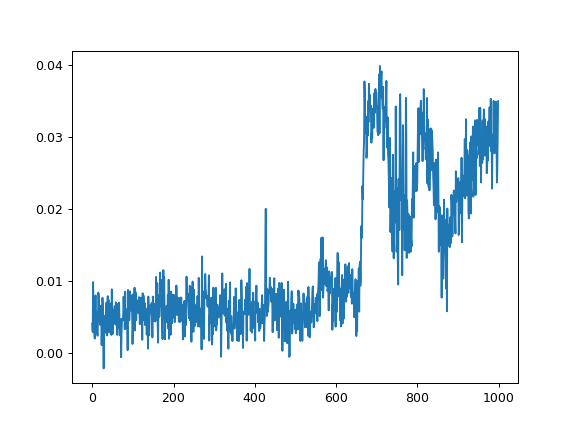

In [195]:
plt.figure()
plt.plot(cc_cat_m)

In [213]:
test = crop(sitr(paths_vids[20]).data(), *crops)

In [214]:
test[0]

array([[129,  43,  87, ...,  44, 119,  10],
       [ 22,  15,   1, ...,   2, 112,  76],
       [ -7,   7,  10, ..., 224, 115,  22],
       ...,
       [  9,  16,  96, ..., -20,   1,  -6],
       [  2,  91,  12, ...,  95,  -6,   1],
       [117, -18, 131, ...,  17,  -9,  62]], dtype=int16)

In [224]:
np.percentile(test, 95)

311.0

<IPython.core.display.Javascript object>


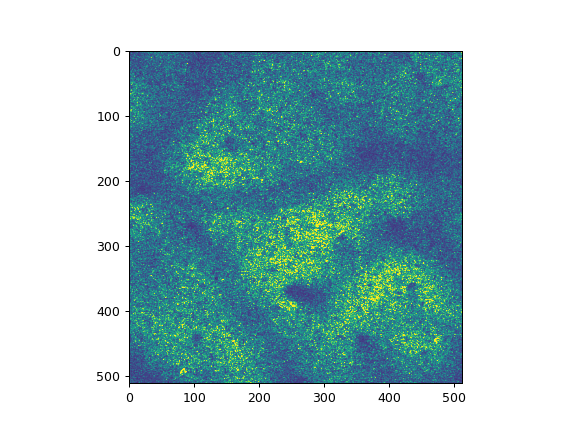

In [221]:
plt.figure()
plt.imshow(test[0], vmax=np.percentile(test, 95))

In [14]:
def clip(ims, val=500):
    return np.clip(ims, a_min=None, a_max=val)

In [227]:
fft_template = torch.conj(torch.fft.fft2(torch.as_tensor(crop(stack, *crops), dtype=torch.float32)))
fft_moving   = torch.fft.fft2(torch.as_tensor(clip(crop(sitr(paths_vids[20]).data(), *crops), val=311), dtype=torch.float32))

R = fft_template[:,None,...] * fft_moving[None,:,...]
R /= torch.abs(R)
cc = torch.fft.fftshift(torch.fft.ifft2(R)).real


In [19]:
sitr = ScanImageTiffReader.ScanImageTiffReader
crops = np.array([[256, 512+256], [0, 512]])


In [230]:
def phase_corr(ims_template, ims_moving):
    fft_template = torch.conj(torch.fft.fft2(torch.as_tensor(ims_template, dtype=torch.float32)))
    fft_moving   = torch.fft.fft2(torch.as_tensor(ims_moving, dtype=torch.float32))

    R = fft_template[:,None,...] * fft_moving[None,:,...]
    R /= torch.abs(R)
    cc = torch.fft.fftshift(torch.fft.ifft2(R), dim=(2,3)).real
    return cc

In [29]:
def reduce_cc(cc, mid_crop_idx=[[252,260], [252,260]]):
    m = mid_crop_idx
    return cc[:,:, m[0][0]:m[0][1], m[1][0]:m[1][1]].mean(dim=(2,3))

In [245]:
cc = [reduce_cc(phase_corr(crop(stack[1:4], *crops), clip(crop(sitr(p).data(), *crops), val=311)), mid_crop_idx=[[248,264], [248,264]]) for p in tqdm(paths_vids[:20])]

  0%|          | 0/20 [00:00<?, ?it/s]

In [123]:
cc = [phase_corr(crop(stack[1:4], *crops), clip(crop(sitr(p).data(), *crops), val=400)).numpy().max(axis=(2,3)) for p in tqdm(paths_vids[:1])]

  0%|          | 0/1 [00:00<?, ?it/s]

In [231]:
cc = [phase_corr(stack[1:4], clip(sitr(p).data(), val=400)).numpy().max(axis=(2,3)) for p in tqdm(paths_vids[18:19])]

  0%|          | 0/1 [00:00<?, ?it/s]

In [177]:
test = phase_corr(crop(stack[1:4], *crops), clip(crop(sitr(paths_vids[0]).data(), *crops), val=311))

<IPython.core.display.Javascript object>


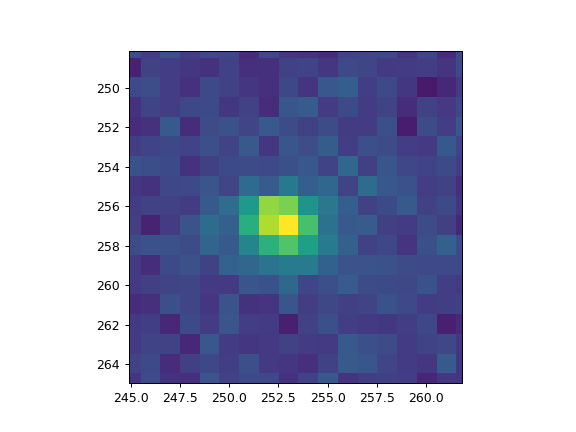

In [178]:
plt.figure()
plt.imshow(test[1][0])

In [246]:
cc_cat = np.concatenate(cc, axis=1)

In [229]:
cc_cat.shape

(3, 1000)

In [172]:
x = np.load(r'C:\Users\Rich Hakim\Desktop\test.npy')

In [179]:
logger = scipy.io.loadmat(r'D:\RH_local\data\BMI_cage_1511_3\mouse_B\20221020\analysis_data\logger.mat', simplify_cells=True)

In [186]:
expParams = scipy.io.loadmat(r'D:\RH_local\data\BMI_cage_1511_3\mouse_B\20221020\analysis_data\expParams.mat', simplify_cells=True)

In [198]:
def phase_correlation(a, b):
    G_a = np.fft.fft2(a)
    G_b = np.fft.fft2(b)
    conj_b = np.ma.conjugate(G_b)
    R = G_a*conj_b
    R /= np.absolute(R)
    r = np.fft.ifft2(R).real
    return r

In [249]:
traces = timeSeries.simple_smooth(cc_cat.T, sig=4, axis=0)

<IPython.core.display.Javascript object>


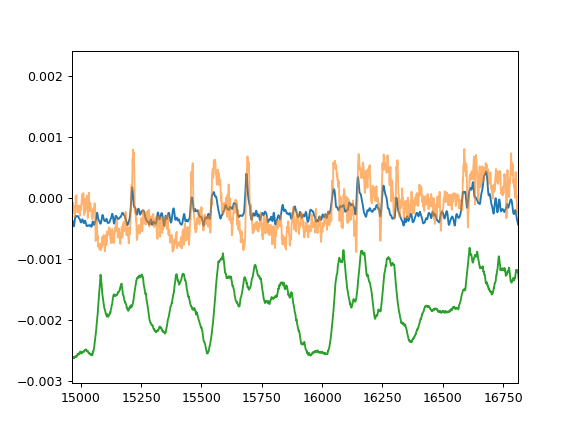

In [258]:
%matplotlib notebook

plt.figure()
# plt.plot(cc_cat.T);
plt.plot((traces[:,1]) * -2 + 0.006);
# plt.plot(timeSeries.simple_smooth(cc_cat.T, sig=4, axis=0)[:,0] - timeSeries.simple_smooth(cc_cat.T, sig=4, axis=0)[:,1]);
# plt.plot(timeSeries.simple_smooth(cc_cat.T, sig=4, axis=0)[:,2] - timeSeries.simple_smooth(cc_cat.T, sig=4, axis=0)[:,1]);
# plt.plot(timeSeries.simple_smooth(cc_cat.T, sig=4, axis=0)[:,2] - timeSeries.simple_smooth(cc_cat.T, sig=4, axis=0)[:,0]);
plt.plot(x[:,:1]/10000, alpha=0.6)
plt.plot(-logger['logger']['motionCorrection'][:,2]/100)
# plt.plot(np.arange(18000,19000), ccm/10 + 0.003)
# plt.plot(-timeSeries.simple_smooth(cc_cat[1], sig=4)*2.5 + 0.016, 'b')

<IPython.core.display.Javascript object>


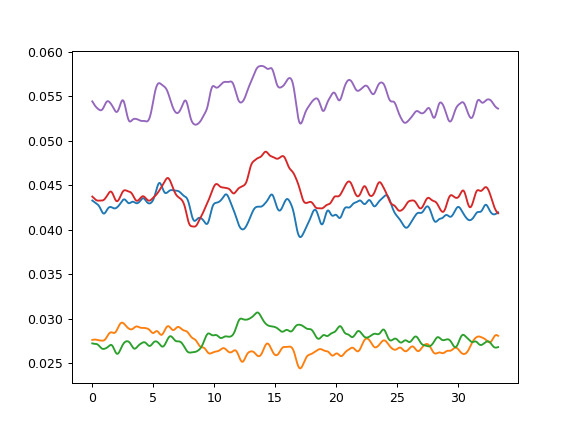

In [201]:
plt.figure()
plt.plot(np.arange(ccm.shape[1])/30, timeSeries.simple_smooth(ccm.T, axis=0, sig=10))

In [177]:
ccm.shape

torch.Size([])

In [159]:
R.shape

torch.Size([5, 1000, 512, 512])

In [162]:
cc.shape

torch.Size([5, 1000, 512, 512])

In [157]:
fft_template.shape

torch.Size([5, 512, 512])

In [155]:
fft_moving.shape

torch.Size([1000, 512, 512])

In [131]:
test = phase_correlation(template_precomp, crop(torch.as_tensor(sitr(paths_vids[0]).data()[0], dtype=torch.float32), *crops), template_precomputed=True)[127:128, 127:128].mean()

In [133]:
test.shape

torch.Size([512, 512])

In [ ]:
plt.figure()
plt.

In [139]:
cc_cat_a = torch.cat([torch.stack(c) for c in cc_a])
cc_cat_m = torch.cat([torch.stack(c) for c in cc_m])
cc_cat_b = torch.cat([torch.stack(c) for c in cc_b])

<IPython.core.display.Javascript object>


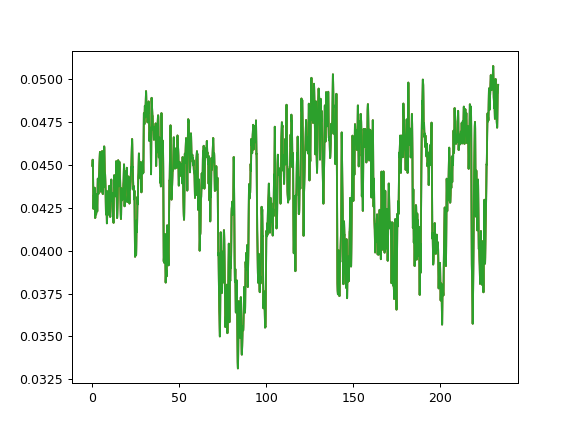

In [121]:
%matplotlib notebook
plt.figure()
# plt.plot(np.arange(len(cc_cat))/30, cc_cat)
plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat_a, sig=5))
# plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat_m, sig=5))
# plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat_b, sig=5))
# plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat, sig=5))
# plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat, sig=5) - timeSeries.simple_smooth(cc_cat2, sig=5))

<IPython.core.display.Javascript object>


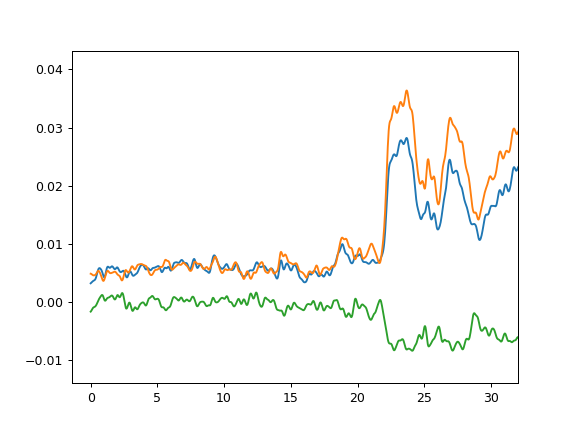

In [141]:
%matplotlib notebook
plt.figure()
# plt.plot(np.arange(len(cc_cat))/30, cc_cat)
plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat_a, sig=5))
plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat_m, sig=5))
# plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat_b, sig=5))
# plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat, sig=5))
plt.plot(np.arange(len(cc_cat_a))/30, timeSeries.simple_smooth(cc_cat_a, sig=5) - timeSeries.simple_smooth(cc_cat_m, sig=5))